# Implementing the multi label remapping

Implements the greedy output label remapping

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

In [2]:
import time

In [3]:
from pylab import *

In [4]:
from IPython.display import *

In [5]:
rcParams['figure.figsize'] = 18,7
rcParams['axes.grid'] = True
rcParams['font.size'] = 15
style.use('dark_background')

In [6]:
from pytorch_utils.train_utils import *
from pytorch_utils.updaters import *

In [7]:
from torchvision.models import *
import torchvision

In [8]:
torch.backends.cudnn.benchmark=True

In [9]:
DEVICE = torch.device('cpu')

# Get the imagenet model

In [10]:
model = resnet18(pretrained=True)

In [11]:
model.eval().to(DEVICE)
for p in model.parameters():
    p.requires_grad = False

In [12]:
def normalize_batch(input, means=[0.485, 0.456, 0.406], stds=[0.229, 0.224, 0.225]):
        ms = torch.tensor(means, device=str(input.device)).view(1,3,1,1)
        ss = torch.tensor(stds, device=str(input.device)).view(1,3,1,1)
#         print(input.device)
#         print(ms.device)
#         out = input[:,:,:,:]
#         out[:,0,:,:] = (input[:,0,:,:] - means[0])/stds[0]
#         out[:,1,:,:] = (input[:,1,:,:] - means[1])/stds[1]
#         out[:,2,:,:] = (input[:,2,:,:] - means[2])/stds[2]
        return (input-ms)/ss

## Get the data

In [13]:
IMAGE_SIZE = (224,224)

In [14]:
from torchvision.datasets import *
from torchvision.transforms import *

In [15]:
transforms = Compose([Grayscale(3),
                      Resize(IMAGE_SIZE),
                      ToTensor()])

In [16]:
total_train_mnist = MNIST('/MNIST',download=True,transform=transforms)
test_mnist = MNIST('/MNIST',train=False,transform=transforms)

Splitting:

In [17]:
training_number = len(total_train_mnist)
val_split = 0.1

train_num = int(training_number*(1-val_split))
val_num = int(training_number*val_split)

train_mnist, val_mnist = torch.utils.data.dataset.random_split(total_train_mnist, 
                [train_num, val_num])

In [18]:
batch_size = 16
train_loader = DataLoader(train_mnist, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_mnist, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=batch_size,shuffle=True)
print(len(train_loader))

3375


In [19]:
transforms = Compose([
                      Resize(IMAGE_SIZE),
                      ToTensor()
                     ])

In [20]:
total_train_cifar = CIFAR10('/CIFAR10',download=True,transform=transforms)
test_cifar = CIFAR10('/CIFAR10',train=False,transform=transforms)

Files already downloaded and verified


Splitting:

In [21]:
training_number_cifar = len(total_train_cifar)
val_split_cifar = 0.1

train_num_cifar = int(training_number_cifar*(1-val_split_cifar))
val_num_cifar = int(training_number_cifar*val_split_cifar)

train_cifar, val_cifar = torch.utils.data.dataset.random_split(total_train_cifar, 
                [train_num_cifar, val_num_cifar])

In [22]:
batch_size_cifar = 32
train_loader_cifar = DataLoader(train_cifar, batch_size=batch_size_cifar,shuffle=True)
val_loader_cifar = DataLoader(val_cifar, batch_size=batch_size_cifar,shuffle=True)
test_loader_cifar = DataLoader(test_cifar, batch_size=batch_size_cifar,shuffle=True)
print(len(train_loader_cifar))

1407


# Histograms and counting

In [23]:
def predict_on_batch(model, batch):
    outputs = model(F.tanh(normalize_batch(batch)))
    pred_labels = torch.argmax(outputs, dim=-1)
    return pred_labels

In [24]:
def getHists(model, train_loader, model_output_count=1000, data_label_count=10):
    """
    Get histrogram of model outputs using dataset for another problem. 
    Example, get histrogram of resnet18 outputs on scaled mnist digits.
    """
    with torch.no_grad():
        hists = torch.zeros(data_label_count,model_output_count)
        d = display(Markdown(''), display_id=f'info{time.time()}')
        i=0
        for imgs, labs in train_loader:
            i+=1
            preds = predict_on_batch(model,imgs.to(DEVICE))
            for l,p in zip(labs,preds):
                hists[l][p]+=1
            d.update(Markdown(f"Batch {i} done"))
            
        return hists

In [25]:
te = iter(train_loader_cifar)

In [26]:
%%timeit
with torch.no_grad():
    imgs, labs  = next(te)
    preds = predict_on_batch(model,imgs.to(DEVICE))

2.74 s ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Get histrograms for resnet18 on cifar

In [ ]:
hists_cifar_resnet18_normtanh = getHists(model, train_loader_cifar,)

In [ ]:
torch.save(hists_cifar_resnet18_normtanh, 'HISTS_CIFAR_resnet18_normtanh.tensor')

In [28]:
hists_cifar_resnet18_normtanh = torch.load('HISTS_CIFAR_resnet18_normtanh.tensor')

In [29]:
h_res18_cif = hists_cifar_resnet18_normtanh.cpu().numpy()

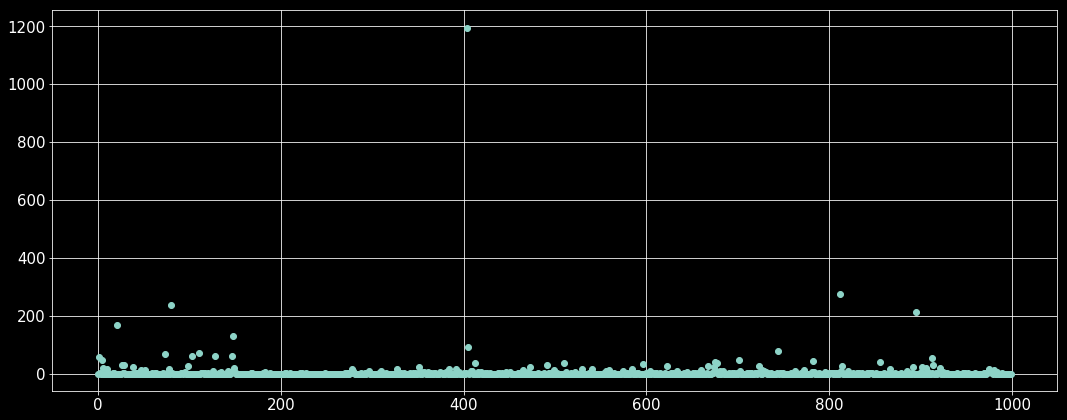

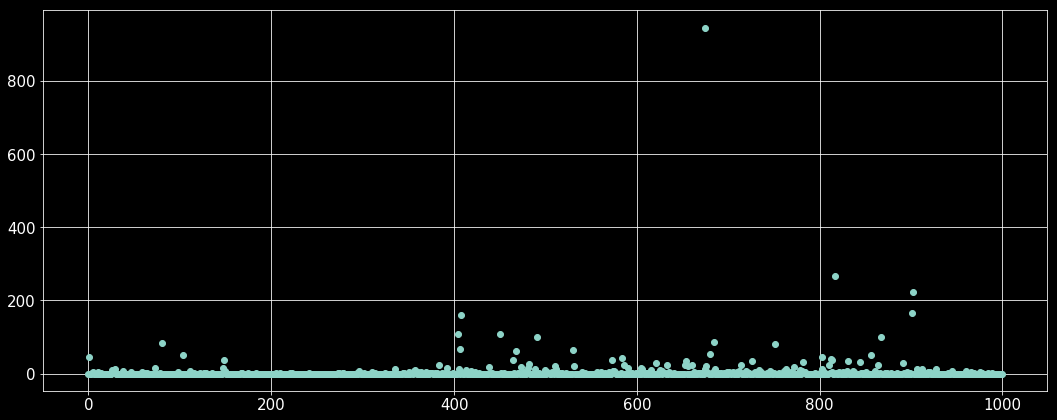

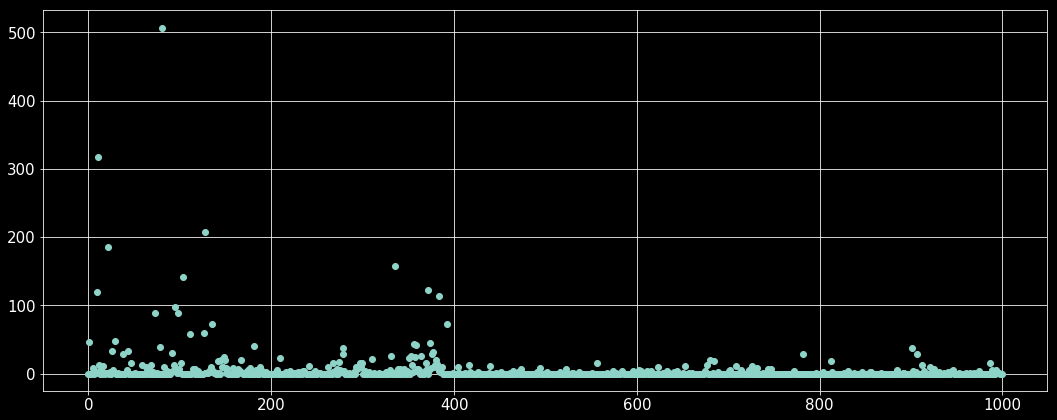

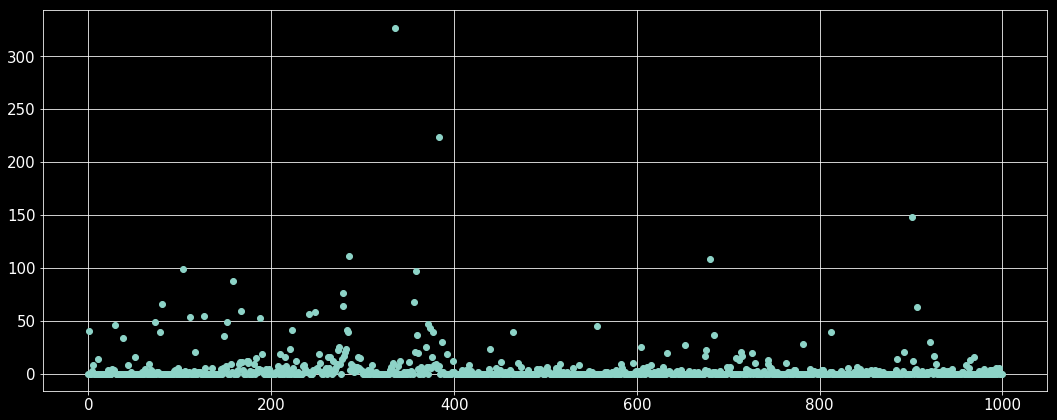

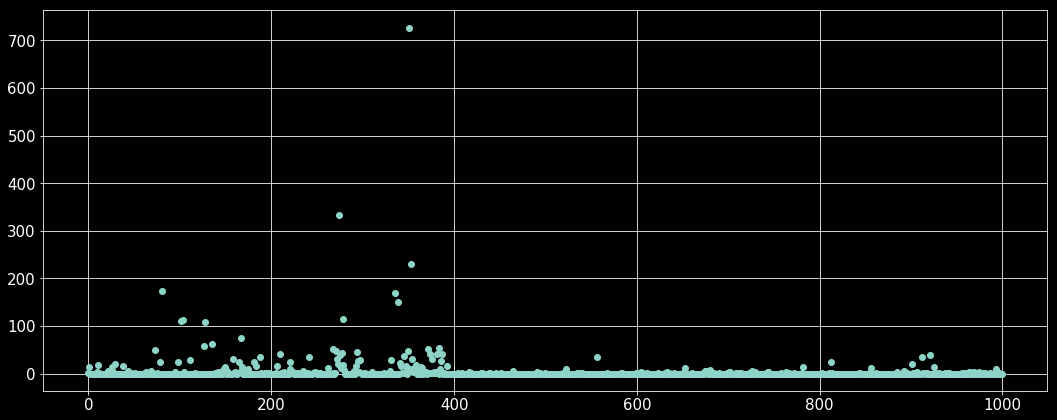

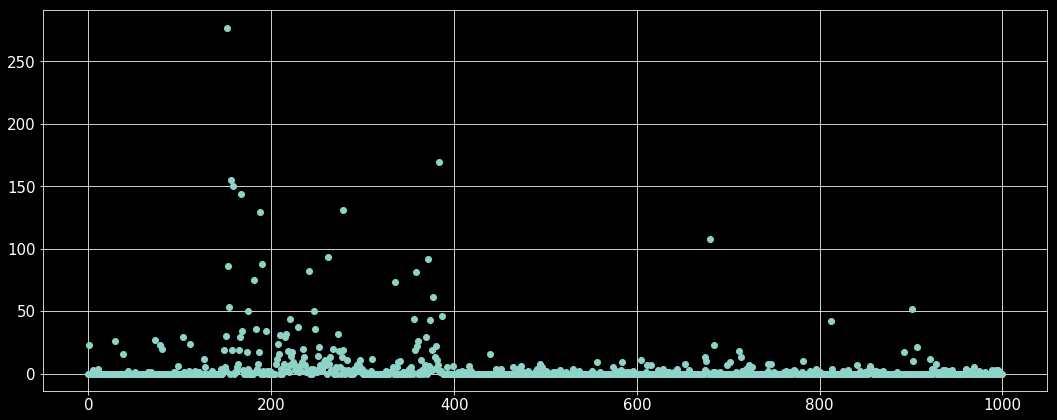

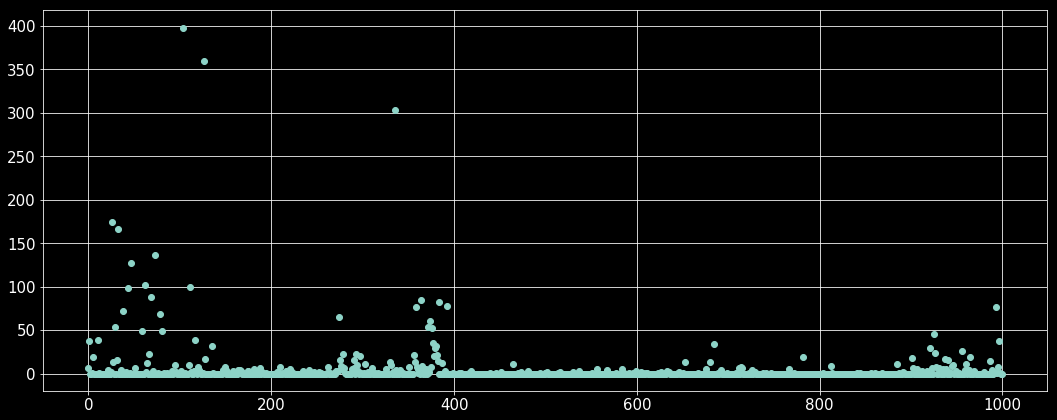

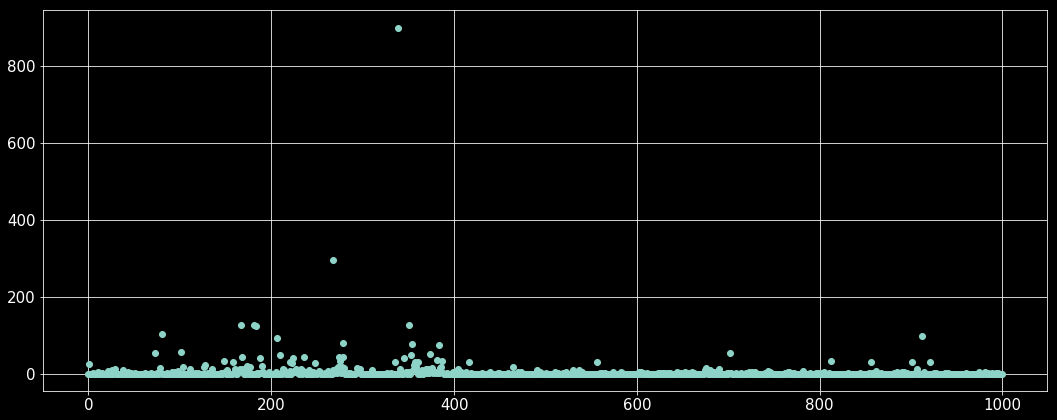

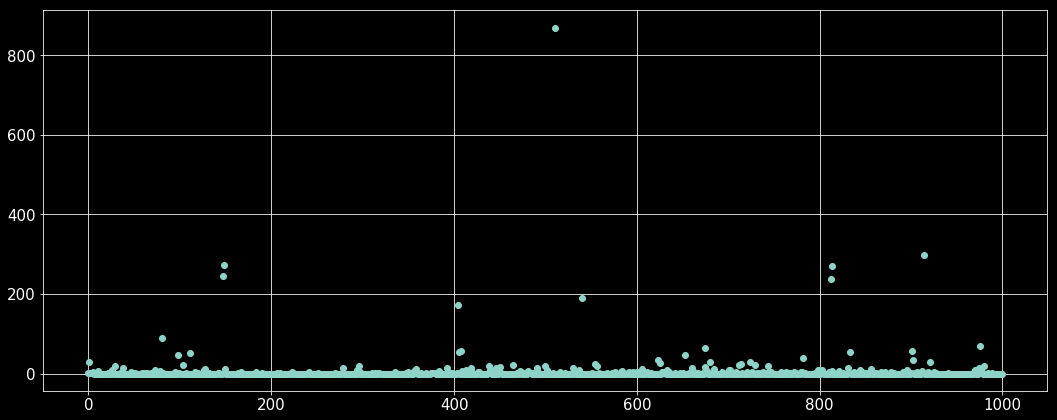

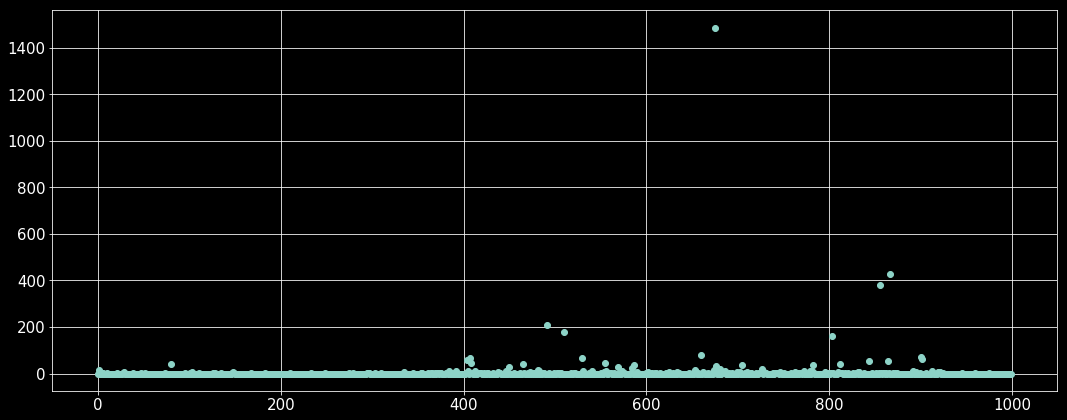

In [30]:
for i in range(10):
    plot(h_res18_cif.T[:,i],'o')
    show()

Check out the top mappings for each cifar label

In [31]:
sorteds = argmax(h_res18_cif.T, axis=0)
argstoreds = argsort(h_res18_cif.T, axis=0)

In [32]:
print(argstoreds[-5:])
print(sorteds)

[[ 21 408 335 680 335 167  32 351 147 510]
 [895 901  21 285  80 158  26 167 814 491]
 [ 80 902 128 901 353 156 335 181 148 856]
 [812 817  10 384 274 384 126 268 914 867]
 [404 675  80 335 351 152 103 339 510 675]]
[404 675  80 335 351 152 103 339 510 675]


In [33]:
h_res18_cif = hists_cifar_resnet18_normtanh.cpu().numpy()
h_res18_cif.shape

(10, 1000)

## This line does the greedy multi label mapping:

In [34]:
resnet18_mapping = argmax(h_res18_cif, axis=0)

Let's test out the mapping without training any adversarial program (basically sets the program to 0)

In [35]:
total_correct = 0
total = 0
for i in range(10):
    correct = h_res18_cif[i,where(resnet18_mapping==i)].sum()
    total_correct += correct
    total += h_res18_cif[i].sum()
    acc = correct/h_res18_cif[i].sum()
    print(i, acc)

print(total_correct/total)

0 0.5350488
1 0.4068704
2 0.46485764
3 0.38814914
4 0.46822223
5 0.5107527
6 0.6599424
7 0.5155694
8 0.6040239
9 0.72922665
0.5284444444444445


That's a pretty high train accuracy using just counting